In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
DATASET_PATH = "/content/drive/MyDrive/TomatoDataset"


In [3]:
import os
os.listdir(DATASET_PATH)


['cnn_train.py', 'train', 'test']

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np


In [5]:
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 10
EPOCHS = 10


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # 20% of training data
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH + "/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",     # This is the training split
    shuffle=True
)

Found 8000 images belonging to 10 classes.


In [7]:

# Validation generator
val_generator = train_datagen.flow_from_directory(
    DATASET_PATH + "/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",   # This is the validation split
    shuffle=False
)

Found 2000 images belonging to 10 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    DATASET_PATH + "/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 984 images belonging to 10 classes.


In [9]:
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False  # Stage 1


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)



In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [19]:
history_1 = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8524s 34s/step - accuracy: 0.8425 - loss: 0.6052 - val_accuracy: 0.8905 - val_loss: 0.3181
Epoch 2/10
156/250 ━━━━━━━━━━━━━━━━━━━━ 43:14 28s/step - accuracy: 0.9167 - loss: 0.2539

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_1.history["accuracy"], label="Train Accuracy")
plt.plot(history_1.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Training Progress")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history_1.history["accuracy"], label="Train Accuracy")
plt.plot(history_1.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history_1.history["loss"], label="Train Loss")
plt.plot(history_1.history["val_loss"], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/best_vgg16_tomato_model.keras",
    monitor="val_accuracy",
    save_best_only=True
)

history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, checkpoint],
    initial_epoch=len(history_1.history["accuracy"])
)

model.save("/content/drive/MyDrive/final_vgg16_tomato_model.keras")

In [ ]:
for layer in base_model.layers[-4:]:
    layer.trainable = True


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
history_unfreeze = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop]
)


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/final_vgg16_tomato_model.keras")


In [ ]:
for layer in model.layers:
    if "block5" in layer.name:
        layer.trainable = True


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
history_unfreeze = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop]
)
model.save("/content/drive/MyDrive/vgg16_tomato_finetuned.keras")


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 169s 674ms/step - accuracy: 0.7851 - loss: 0.6667 - val_accuracy: 0.8400 - val_loss: 0.4805
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 168s 670ms/step - accuracy: 0.8235 - loss: 0.5307 - val_accuracy: 0.8685 - val_loss: 0.3984
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 168s 671ms/step - accuracy: 0.8585 - loss: 0.4164 - val_accuracy: 0.8680 - val_loss: 0.3903
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 177s 707ms/step - accuracy: 0.8704 - loss: 0.3756 - val_accuracy: 0.8880 - val_loss: 0.3213
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 171s 682ms/step - accuracy: 0.8819 - loss: 0.3407 - val_accuracy: 0.8970 - val_loss: 0.3124
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 169s 675ms/step - accuracy: 0.9019 - loss: 0.2919 - val_accuracy: 0.9180 - val_loss: 0.2630
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 172s 686ms/step - accuracy: 0.9074 - loss: 0.2833 - val_accuracy: 0.9100 - val_loss: 0.2538
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 170s 680ms/step - accuracy: 0.9194 -

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/vgg16_tomato_finetuned.keras")


In [ ]:
import numpy as np

test_generator.reset()

pred_probs = model.predict(test_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 788s 25s/step


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))


                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.92      0.98      0.95       100
                        Tomato___Early_blight       0.95      0.81      0.88       100
                         Tomato___Late_blight       0.93      0.92      0.92       100
                           Tomato___Leaf_Mold       0.98      0.88      0.93       100
                  Tomato___Septoria_leaf_spot       0.84      0.96      0.90       100
Tomato___Spider_mites Two-spotted_spider_mite       0.85      0.99      0.91        84
                         Tomato___Target_Spot       0.93      0.89      0.91       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       1.00      0.91      0.95       100
                 Tomato___Tomato_mosaic_virus       0.92      0.97      0.95       100
                             Tomato___healthy       0.98      0.98      0.98       100

                                     accu

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)


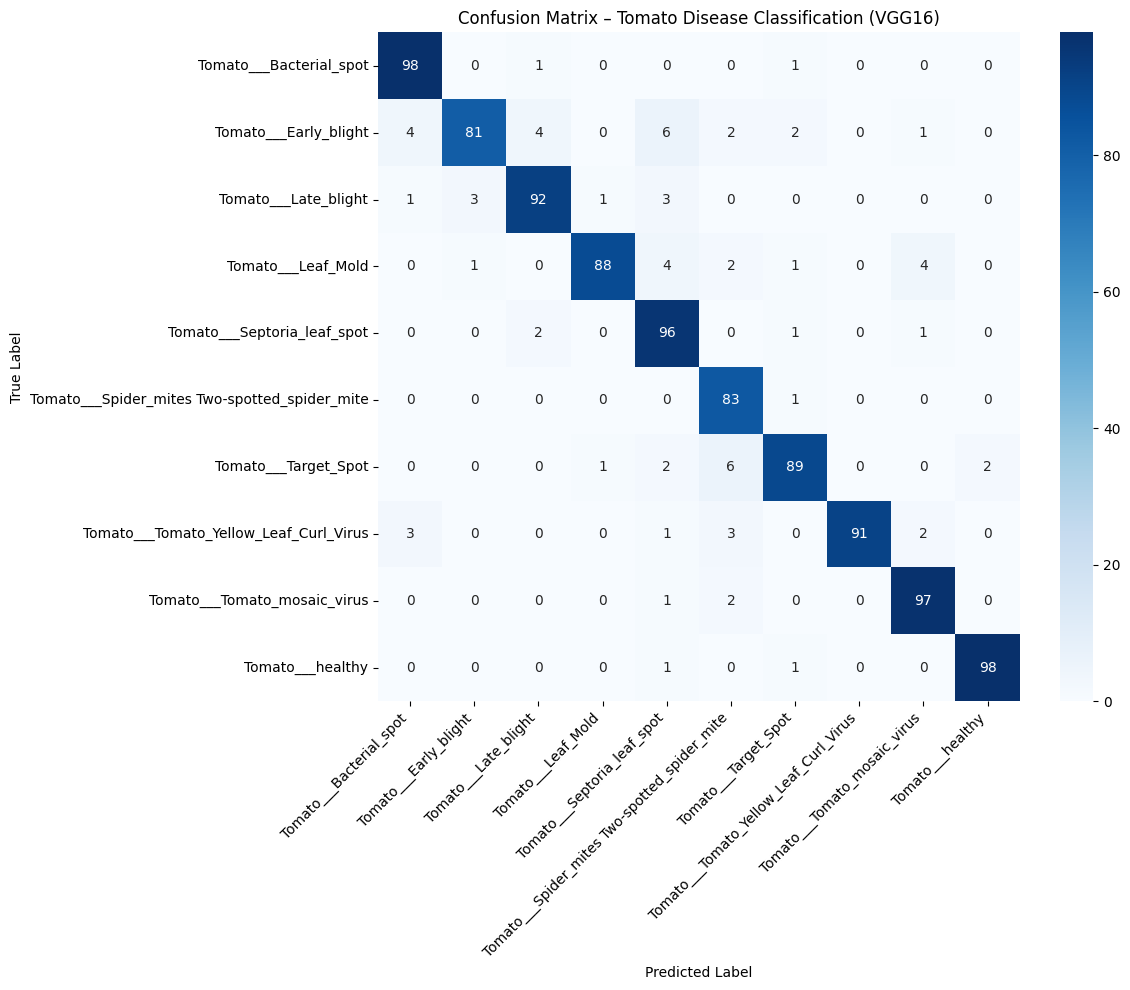

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Tomato Disease Classification (VGG16)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
class_accuracy = cm.diagonal() / cm.sum(axis=1)

for name, acc in zip(class_names, class_accuracy):
    print(f"{name}: {acc:.2%}")


Tomato___Bacterial_spot: 98.00%
Tomato___Early_blight: 81.00%
Tomato___Late_blight: 92.00%
Tomato___Leaf_Mold: 88.00%
Tomato___Septoria_leaf_spot: 96.00%
Tomato___Spider_mites Two-spotted_spider_mite: 98.81%
Tomato___Target_Spot: 89.00%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 91.00%
Tomato___Tomato_mosaic_virus: 97.00%
Tomato___healthy: 98.00%


In [ ]:
print("Train samples:", train_generator.samples)
print("Validation samples:", val_generator.samples)
print("Test samples:", test_generator.samples)


Train samples: 8000
Validation samples: 2000
Test samples: 984


In [10]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/vgg16_tomato_finetuned1.keras")

In [22]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


31/31 ━━━━━━━━━━━━━━━━━━━━ 794s 25s/step - accuracy: 0.9185 - loss: 0.2367
Test Accuracy: 92.78%


In [35]:
import numpy as np
from tensorflow.keras.preprocessing import image

CONFIDENCE_THRESHOLD = 0.75

img_path = "/content/drive/MyDrive/healthyy.JPG"

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)

confidence = np.max(pred)
predicted_class = np.argmax(pred, axis=1)[0]

class_names = list(train_generator.class_indices.keys())

if confidence < CONFIDENCE_THRESHOLD:
    print("Prediction: UNKNOWN")
    print(f"Confidence too low: {confidence:.2f}")
else:
    print("Predicted disease:", class_names[predicted_class])
    print(f"Confidence: {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted disease: Tomato___healthy
Confidence: 1.00


In [11]:
for layer in model.layers[:-8]:
    layer.trainable = False


In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/best_vgg16_tomato_model_v2.keras",
    monitor="val_accuracy",
    save_best_only=True
)

history_finetune_v2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)
model.save("/content/drive/MyDrive/vgg16_tomato_model_v2.keras")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
  1/250 ━━━━━━━━━━━━━━━━━━━━ 2:34:43 37s/step - accuracy: 0.9375 - loss: 0.1712